In [1]:
from pymongo import MongoClient
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
import numpy as np
import math
import gc

%matplotlib inline  

client = MongoClient(port=27123)
db = client.frevue_data
coll = db.Trips
#cursor = coll.find({"Owner": "United Kingdom, London, UPS"})

# import data and extract list of data owner and the count of data entries for each data owner 

In [2]:
# this section check the number of partners in the database
# choose a partner and check the number of unique vehicles
# then for each vehicle check the number of available days

cursor1 = coll.aggregate([
        {"$group": {"_id": "$Owner", "NumberOfRecords": {"$sum": 1}}}
    ])
array = list(cursor1)
vehlist = pd.DataFrame(array)    #list of operation partners
print vehlist

    NumberOfRecords                                          _id
0               413                Netherlands, Rotterdam, EMOSS
1             12675      Netherlands, Amsterdam & Rotterdam, TNT
2               161              United Kingdom, London, Clipper
3              1096                        Portugal, Lisbon, CTT
4               541             Netherlands, Amsterdam, Heineken
5              1143  Spain, Madrid, Calidad Pascual & SEUR & TNT
6              1652                  Netherlands, Rotterdam, UPS
7              2987  Netherlands, Amsterdam & Rotterdam, TNT RAW
8               319             Netherlands, Rotterdam, Heineken
9              1589                       Portugal, Lisbon, EMEL
10            15800                  United Kingdom, London, UPS
11               68                          Italy, Milano, AMAT


# choose a data owner

In [108]:
curpartner = vehlist.iloc[5,1]   #current partner can set up a loop  ********************
print "current data owner selected is " + curpartner

current data owner selected is Spain, Madrid, Calidad Pascual & SEUR & TNT


# now extract the number of vehicles (vehicleid) available for the chosen partner and the number of days which data is available for each vehicle

In [109]:
# check valid recordings (distance bigger than 0)
cursor2 = coll.find(
        {"$and": [
                 {"Owner": curpartner},
                 {"Distance": {"$gt": 0}}
                ]
        })
PD_Fields = ['TripId', 'Owner', 'VehicleId', 'Frequency', 'Aggregation', 'Distance', 'StateOfChargeStart', 'StateOfChargeEnd', 
            'StateOfChargeMax', 'StateOfChargeMin', 'StateOfChargeUp', 'StateOfChargeDown', 'StartTime', 'EndTime', 'Duration',
            'Extras']
PartnerData = pd.DataFrame(list(cursor2), columns=PD_Fields)
PartnerData['sday'] = [x.date() for x in PartnerData['StartTime']]
PartnerData['eday'] = [x.date() for x in PartnerData['EndTime']]
# printing
Veh_num = len(PartnerData['VehicleId'].unique()) #count the number of vehilces
print "Total number of vehicle is " + str(Veh_num) + " from " + curpartner    #number of vehicles

check = sum(PartnerData['sday'] <> PartnerData['eday'])
print "the number of a vehicle with different strip start and end dates is " + str(check)

# check how many days worth of data is availale for each vehicle
# PartnerData['newVID'] = PartnerData['VehicleId'].str[:6] ### ONLY FOR UPS (their data seems to have duplicate vehilces)
# Veh_num2 = len(PartnerData['newVID'].unique())
# print Veh_num2
#veh_days = pd.DataFrame(PartnerData.groupby('newVID').size().rename('numofdays'))
veh_days = pd.DataFrame(PartnerData.groupby('VehicleId').size().rename('numofdays'))
veh_days = veh_days.reset_index(range(veh_days.count()))
veh_days['VID'] = veh_days.index + 1
print "Summary of data availability for each vehicle"
print veh_days


# merge to get unique vehilce ID for each vehicle (for plotting purpose)
#PartnerData = pd.merge(PartnerData, veh_days, left_on = "newVID", right_on = "newVID")
PartnerData = pd.merge(PartnerData, veh_days, left_on = "VehicleId", right_on = "VehicleId")

#tripid should note be used anymore
# PartnerData['TripId'] = pd.to_datetime(PartnerData['TripId'])

Total number of vehicle is 4 from Spain, Madrid, Calidad Pascual & SEUR & TNT
the number of a vehicle with different strip start and end dates is 3
Summary of data availability for each vehicle
                             VehicleId  numofdays  VID
0                 1635 HPS (CP, IVECO)        101    1
1   5433 HJB, (TNT, Renault Kangoo ZE)        228    2
2   5563 HJB (SEUR, Renault Kangoo ZE)        456    3
3  6886 HRB (CD, Mercedes Vito E-cell)        358    4


# optional - if the number of vehicle with different trip start and end dates is not zero

In [110]:
PartnerData[PartnerData['sday'] <> PartnerData['eday']]

,TripId,Owner,VehicleId,Frequency,Aggregation,Distance,StateOfChargeStart,StateOfChargeEnd,StateOfChargeMax,StateOfChargeMin,StateOfChargeUp,StateOfChargeDown,StartTime,EndTime,Duration,Extras,sday,eday,numofdays,VID
95,2014-10-28,"Spain, Madrid, Calidad Pascual & SEUR & TNT","1635 HPS (CP, IVECO)",20,0,27402.525869,0.0,0.0,0.0,0.0,0.0,0.0,2014-10-27 23:42:38.515,2014-10-28 11:33:43.986,42665,None,2014-10-27,2014-10-28,101,1
120,2014-10-10,"Spain, Madrid, Calidad Pascual & SEUR & TNT","5433 HJB, (TNT, Renault Kangoo ZE)",20,0,17235.860910,92.0,92.0,92.0,92.0,0.0,0.0,2014-10-09 23:34:00.811,2014-10-10 08:11:30.398,31049,None,2014-10-09,2014-10-10,228,2
336,2014-06-03,"Spain, Madrid, Calidad Pascual & SEUR & TNT","5563 HJB (SEUR, Renault Kangoo ZE)",20,0,73283.540128,100.0,50.0,100.0,50.0,4.0,-54.0,2014-06-02 22:27:23.004,2014-06-03 11:54:16.265,48413,None,2014-06-02,2014-06-03,456,3


# NOTE: Plotting of data availability is based on the "endtime" record

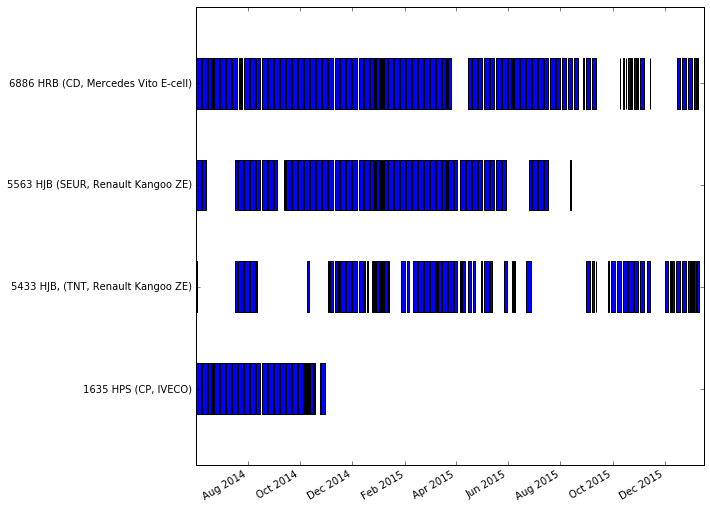

In [111]:
# plotting data availability
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(2,2,1)

for i in PartnerData['VehicleId'].unique():
    datelist = []
    selVehData = PartnerData[PartnerData['VehicleId']==i]
    curID = selVehData['VID'].iloc[0]
    sdate = selVehData['eday'].min()
    edate = selVehData['eday'].max()
    diffdate = edate - sdate
    dateswitch = 0
    curdate = sdate
    for j in range(0, int(diffdate.days)):
        predate = curdate                          #previous date
        curdate = curdate + dt.timedelta(days=1)     #current date
        if any(selVehData['eday'] == curdate) and dateswitch == 1:
            sdate = curdate
            dateswitch = 0
        if (not any(selVehData['eday'] == curdate)) and dateswitch == 0:   #if current date is not available, call plotting
            #pltmain(sdate, predate)
            datelist.append((mpl.dates.date2num(sdate), mpl.dates.date2num(curdate)-mpl.dates.date2num(sdate)))
            dateswitch = 1
    ax1.broken_barh(datelist, (curID,0.5))
ax1.xaxis_date()
ax1.set_xlim(PartnerData['eday'].min(), PartnerData['eday'].max())
ax1.set_ylim(0.5, len(PartnerData['VehicleId'].unique())+1)
ax1.yaxis.set_ticks(np.arange(1.25, len(PartnerData['VehicleId'].unique())+1))
ax1.set_yticklabels(PartnerData['VehicleId'].unique())
fig.autofmt_xdate()

# plotting of total distance per day

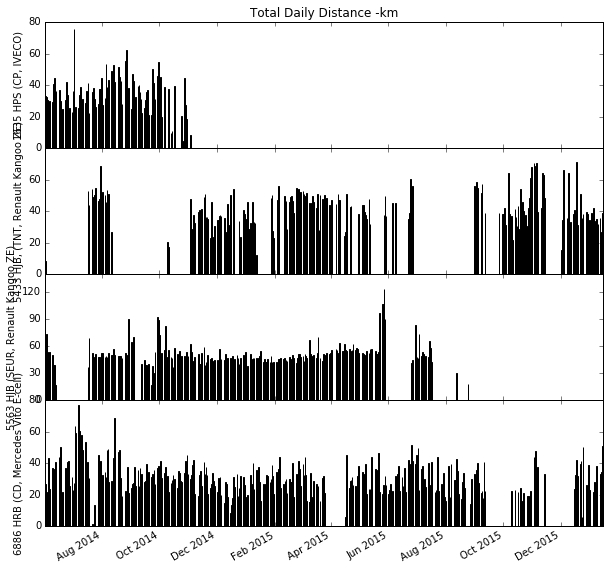

In [112]:
fig2 = pl.figure(figsize=(10, 10))
fig2.subplots_adjust(hspace=0.0)
# pl.subplots_adjust(hspace=0.1)
number_of_subplots=len(PartnerData['VehicleId'].unique())

for i,v in enumerate(xrange(number_of_subplots)):
    vehid = PartnerData['VehicleId'].unique()[i]
    selVehData2 = PartnerData[PartnerData['VehicleId']==vehid]

    sdate2 = selVehData2['eday'].min()
    edate2 = selVehData2['eday'].max()

    delta2 = edate2-sdate2
    
    v = v+1
    ax2 = fig2.add_subplot(number_of_subplots,1,v)
    ax2.bar(mpl.dates.date2num(selVehData2['eday']), selVehData2['Distance']/1000, color='black')

    ax2.xaxis_date()
    ax2.set_xlim(PartnerData['eday'].min(), PartnerData['eday'].max())
    ax2.set_ylabel(vehid)
    if i == 0:
        ax2.set_title("Total Daily Distance -km")
    maxdis = max(selVehData2['Distance']/1000)
    ax2.set_yticks(range(0,int(maxdis*1.1), int(math.ceil((maxdis*1.1/5)/10)*10)))
    
fig2.autofmt_xdate()


# some statistics of daily distance for each of the vehicle

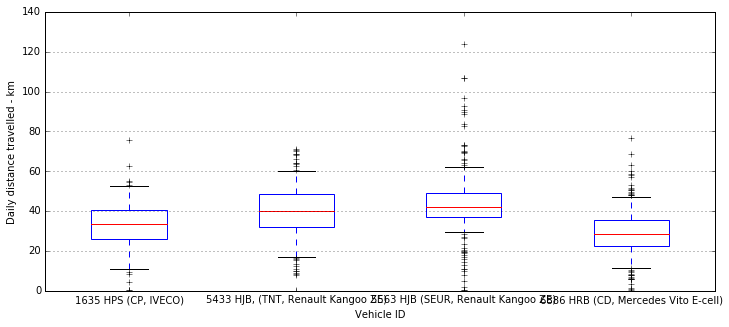

In [113]:
# box plot for distance statistics

fig3 = plt.figure(figsize=(12, 5))
ax3 = fig3.add_subplot(1,1,1)
# # Random test data
# np.random.seed(123)
# all_data = [np.random.normal(0, std, 100) for std in range(1, 4)]

lsdata = []
lsveh = []
boxplotdata = []
for i in PartnerData['VehicleId'].unique():
    lsveh.append(i)
    currdata = np.array(PartnerData[PartnerData['VehicleId']==i]['Distance']/1000)
    boxplotdata.append(currdata)

boxplotdata = np.array(boxplotdata)
# boxplotdata['VehicleId'] = PartnerData['VehicleId']

# rectangular box plot
ax3.boxplot(boxplotdata,
            vert=True,   # vertical box aligmnent
            patch_artist=True, 
            whis=[5, 95])


# adding horizontal grid lines
ax3.yaxis.grid(True)
ax3.set_xticks([y+1 for y in range(len(PartnerData['VehicleId'].unique()))], )
ax3.set_xlabel('Vehicle ID')
ax3.set_ylabel('Daily distance travelled - km')

# add x-tick labels
plt.setp(ax3, xticks=[y+1 for y in range(len(PartnerData['VehicleId'].unique()))],
         xticklabels=lsveh)

# plt.show()

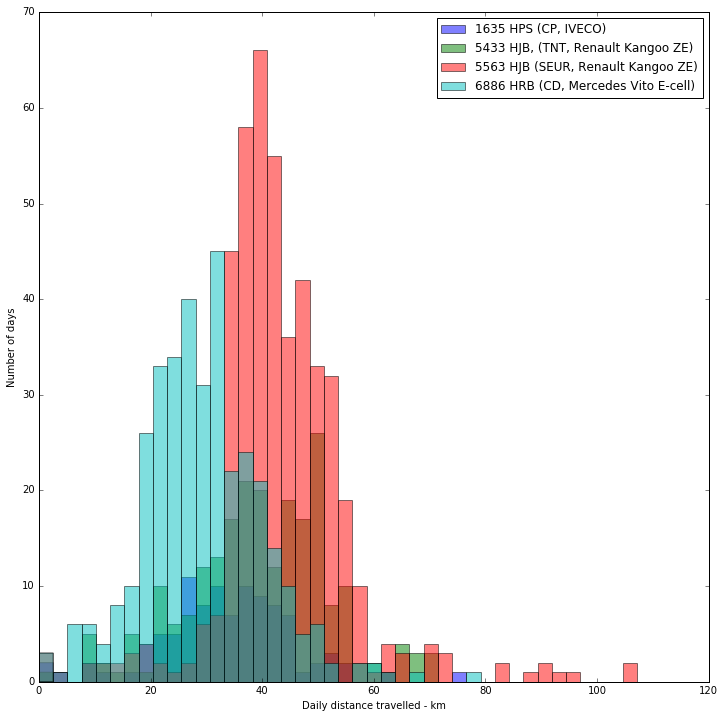

In [114]:
# histogram 

fig4 = plt.figure(figsize=(12, 12))
ax4 = fig4.add_subplot(1,1,1)

bins = np.linspace(0,120,48)

# rectangular box plot
for i in range(len(boxplotdata)):
    ax4.hist(boxplotdata[i], bins, alpha=0.5, label = lsveh[i])
ax4.legend(loc='upper right')
    
# adding horizontal grid lines
# ax3.yaxis.grid(True)
# ax3.set_xticks([y+1 for y in range(len(PartnerData['VehicleId'].unique()))], )
ax4.set_ylabel('Number of days')
ax4.set_xlabel('Daily distance travelled - km')


# now look at telematics data (seconds data)

In [115]:
#import detailed data and create a dataframe
# cursor2 = coll.find(
#         {"$and": [
#                  {"Owner": curpartner},
#                  {"Distance": {"$gt": 0}}
#                 ]
#         })

cursor2 = coll.find({"Owner": curpartner})

DetailedData = []

for record in cursor2:
    veh_id = record['VehicleId']
    for datapoint in record['DataPoints']:
        eachdatapoint = {
            "timestamp": datapoint.get('ts'),
            "lat": datapoint.get('lat'),
            "lon": datapoint.get('lon'),
            "alt": datapoint.get('alt'),
            "speed": datapoint.get('s'),
            "soc": datapoint.get('soc'),
            "range": datapoint.get('r'),
            "batterytemp": datapoint.get('tb'),
            "cabtemp": datapoint.get('ti'),
            "outsidetemp": datapoint.get('to'),
            "throttle": datapoint.get('thr'),
            "ignition": datapoint.get('i'),
            'VehID': veh_id
        }
        DetailedData.append(eachdatapoint)
gc.collect()

DetailedData = pd.DataFrame(DetailedData).sort_values(by = 'timestamp')
DetailedData = DetailedData.reset_index(drop=True)

# plotting of the state of charge status over the periods

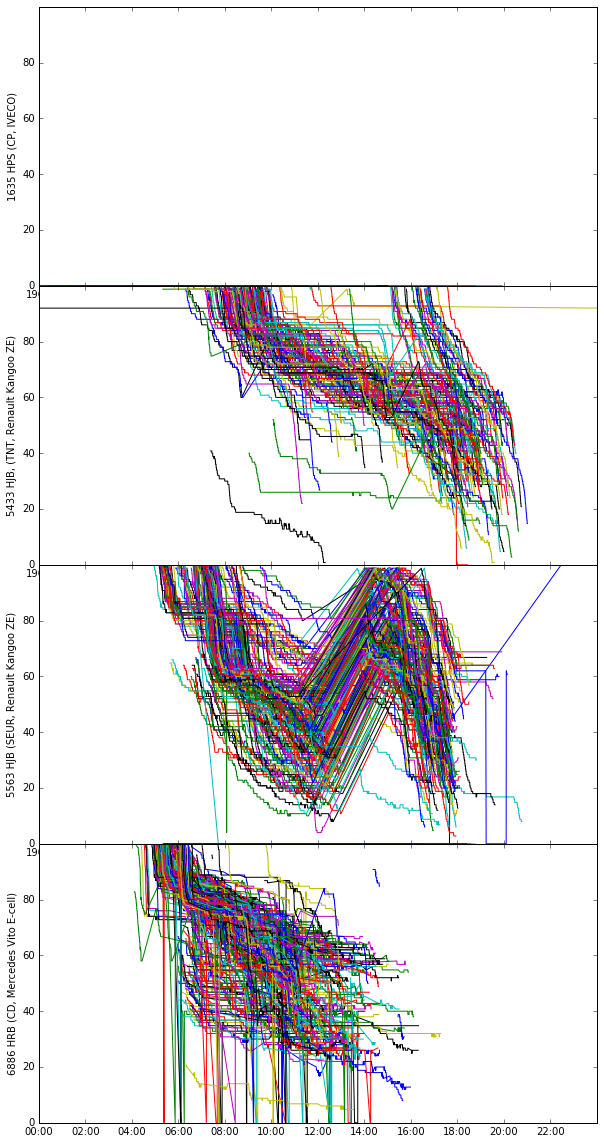

In [121]:

DetailedData['time'] = [x.time().strftime("%H:%M:%S") for x in DetailedData['timestamp']]
DetailedData['date'] = [x.date() for x in DetailedData['timestamp']]

fig5 = pl.figure(figsize=(10, 20))
fig5.subplots_adjust(hspace=0.0)
# pl.subplots_adjust(hspace=0.1)
number_of_subplots=len(PartnerData['VehicleId'].unique())

for i,v in enumerate(xrange(number_of_subplots)):
    vehid5 = PartnerData['VehicleId'].unique()[i]
    selVehData5 = DetailedData[DetailedData['VehID']==vehid5]
#     datelist = [dt.datetime.strptime(str(x), "%H:%M:%S") for x in selDate['time']]
    datemin = dt.datetime.strptime("1900-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
    datemax = dt.datetime.strptime("1900-01-02 00:00:00", "%Y-%m-%d %H:%M:%S")
    v = v+1
    ax5 = fig5.add_subplot(number_of_subplots,1,v)
    for j in selVehData5['date'].unique():
        selDate = selVehData5[selVehData5['date'] ==j]
        ax5.plot(mpl.dates.date2num([dt.datetime.strptime(x, "%H:%M:%S") for x in selDate['time']]), 
                 selDate['soc'])
    ax5.set_ylabel(vehid5)
    ax5.set_ylim(0, 100)
    ax5.set_yticks(range(0,100,20))
    ax5.set_xlim(datemin,datemax)
    ax5.set_xticks(np.arange(datemin, datemax, (datemax - datemin)/12))

xfmt = mpl.dates.DateFormatter('%H:%M')
ax5.xaxis.set_major_formatter(xfmt)
    
# fig5.autofmt_xdate()


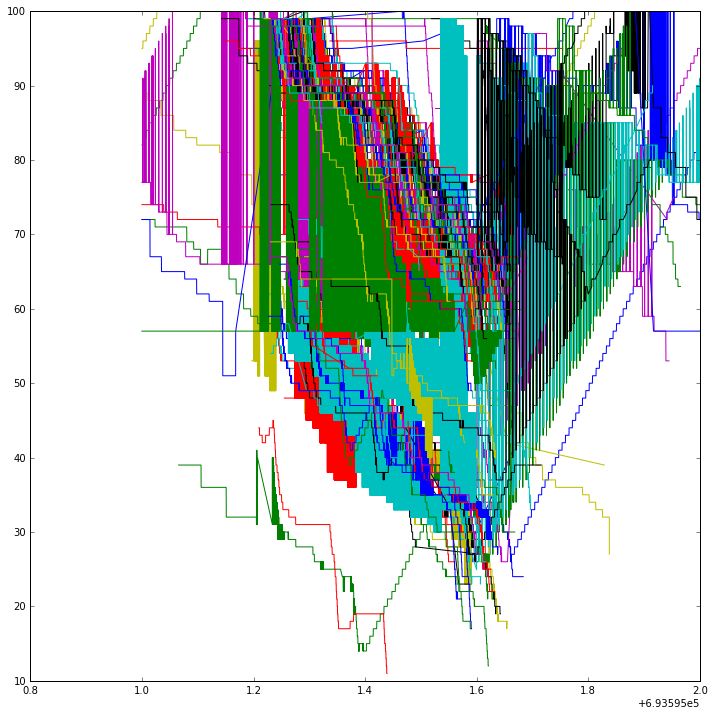

In [67]:
fig5 = plt.figure(figsize=(12, 12))
ax5 = fig5.add_subplot(1,1,1)
selVehData5 = DetailedData[DetailedData['VehID']=='GINAF 001']
for j in selVehData5['date'].unique():
    selDate = selVehData5[selVehData5['date'] ==j]
    ax5.plot(mpl.dates.date2num([dt.datetime.strptime(str(x), "%H:%M:%S") for x in selDate['time']]), 
             selDate['soc'])


In [117]:
DetailedData

,VehID,alt,batterytemp,cabtemp,ignition,lat,lon,outsidetemp,range,soc,speed,throttle,timestamp,time,date
0,"1635 HPS (CP, IVECO)",618.0,None,None,None,40.389420,-3.695664,None,None,0.0,0.0,None,2014-06-02 05:51:52.428,05:51:52.428000,2014-06-02
1,"1635 HPS (CP, IVECO)",606.0,None,None,None,40.389496,-3.695573,None,None,0.0,5.0,None,2014-06-02 05:52:12.499,05:52:12.499000,2014-06-02
2,"1635 HPS (CP, IVECO)",583.0,None,None,None,40.390358,-3.695501,None,None,0.0,11.0,None,2014-06-02 05:52:32.629,05:52:32.629000,2014-06-02
3,"1635 HPS (CP, IVECO)",581.0,None,None,None,40.390610,-3.694992,None,None,0.0,1.0,None,2014-06-02 05:52:52.760,05:52:52.760000,2014-06-02
4,"1635 HPS (CP, IVECO)",574.0,None,None,None,40.391556,-3.695004,None,None,0.0,29.0,None,2014-06-02 05:53:12.890,05:53:12.890000,2014-06-02
5,"1635 HPS (CP, IVECO)",574.0,None,None,None,40.392857,-3.694871,None,None,0.0,22.0,None,2014-06-02 05:53:32.961,05:53:32.961000,2014-06-02
6,"1635 HPS (CP, IVECO)",574.0,None,None,None,40.394409,-3.694711,None,None,0.0,37.0,None,2014-06-02 05:53:53.031,05:53:53.031000,2014-06-02
7,"1635 HPS (CP, IVECO)",583.0,None,None,None,40.396423,-3.694561,None,None,0.0,35.0,None,2014-06-02 05:54:13.162,05:54:13.162000,2014-06-02
8,"1635 HPS (CP, IVECO)",597.0,None,None,None,40.398277,-3.694504,None,None,0.0,32.0,None,2014-06-02 05:54:33.292,05:54:33.292000,2014-06-02
9,"1635 HPS (CP, IVECO)",615.0,None,None,None,40.399258,-3.694237,None,None,0.0,16.0,None,2014-06-02 05:54:53.423,05:54:53.423000,2014-06-02


In [106]:
PartnerData[PartnerData['VehicleId']==i]['Distance']

0         77.548528
1       4134.428466
2       2451.548912
3        175.761655
4       1623.822127
5        181.301679
6       3103.328227
7       6613.021467
8        289.922181
9       1841.947230
10      1468.276913
11      1190.514773
12      1666.458008
13      1240.781769
14      1616.809155
15      2935.666735
16      5957.876422
17        86.773493
18      4201.864847
19      1110.998327
20      2188.124006
21        30.395590
22      9707.510010
23      7742.228408
24       794.228783
25      5417.574543
26       478.351729
27      1314.895143
28      1305.944977
29      1920.426044
           ...     
244       56.558139
245     4031.628294
246      474.484942
247     3251.501928
248     2390.084180
249      280.184760
250     2960.592351
251      837.294178
252     1597.554870
253      265.036937
254     2859.141802
255     3939.735004
256     5500.903857
257       42.072780
258     2296.128651
259      986.838663
260     2330.788146
261    10711.516285
262     3675.946191


# need to check whether there are multiple trips from a same vehicle in a single day

In [ ]:
sum(PartnerData['sday'] <> PartnerData['eday'])

In [ ]:
PartnerData.head(5)

In [ ]:
# plotting data availability
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(2,2,1)

for i in PartnerData['VehicleId'].unique():
    datelist = []
    selVehData = PartnerData[PartnerData['VehicleId']==i]
    curID = selVehData['VID'].iloc[0]
    sdate = selVehData['TripId'].min()
    edate = selVehData['TripId'].max()
    diffdate = edate - sdate
    dateswitch = 0
    curdate = sdate
    for j in range(0, int(diffdate.days)):
        predate = curdate                          #previous date
        curdate = curdate + dt.timedelta(days=1)     #current date
        if any(selVehData['TripId'] == curdate) and dateswitch == 1:
            sdate = curdate
            dateswitch = 0
        if (not any(selVehData['TripId'] == curdate)) and dateswitch == 0:   #if current date is not available, call plotting
            #pltmain(sdate, predate)
            datelist.append((mpl.dates.date2num(sdate), mpl.dates.date2num(curdate)-mpl.dates.date2num(sdate)))
            dateswitch = 1
    ax1.broken_barh(datelist, (curID,0.5))
ax1.xaxis_date()
ax1.set_xlim(PartnerData['TripId'].min(), PartnerData['TripId'].max())

In [ ]:
PartnerData.head(5)

In [ ]:
mpl.dates.date2num(dt.datetime.now())

In [ ]:
curdate = sdate + dt.timedelta(days=1)
print curdate
any(selVehData['TripId'] == curdate)

In [ ]:
#import datetime
#tt = datetime.datetime.strptime(PartnerData['TripId'], "%Y-%m-%d")
PartnerData['TripId'] = pd.to_datetime(PartnerData['TripId'])
#tt.apply(lambda x: x.strftime('%Y-%m-%d'))

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(2,2,1)
#for i in range(0, PartnerData['TripId'].count()):
ax1.broken_barh(PartnerData['TripId'], PartnerData['VID'])

In [ ]:
cursor = coll.find(
        {"$and": [
                 {"Owner": "United Kingdom, London, UPS"},
                 {"Distance": {"$gt": 0}}
                ]
        })
UPSLondon = pd.DataFrame(list(cursor))

In [ ]:
cursor2 = coll.aggregate([
    {"$match": {"$and": [
                        {"Owner": vehlist.iloc[0,1]}, 
                        {"Distance": {"$gt": 0}}
                ]}
    },
    {"$group": {"_id": "$VehicleId", "AverageDistance": {"$avg": "$Distance"}}}
])

In [ ]:
print PartnerData.head(n=10)
PartnerData.iloc[0,5]
len(PartnerData['VehicleId'].unique())

In [ ]:
cursor1 = coll.aggregate([
        {"$group": {"_id": "$Owner", "NumberOfTrips": {"$sum": 1}}}
    ])
array = list(cursor1)
vehlist = pd.DataFrame(array)    #list of operation partners
curpartner = vehlist.iloc[7,1]   #current partner can set up a loop  ********************
print curpartner